In [1]:
#view 600*200 dataframe
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

library(corrplot)
library("Hmisc")


#----------NA row remove function----------
na_rm <- function(data, cols) {
  mask <- complete.cases(data[cols, ])
  return(data[mask, ])
}
#mRNA_f <- t(na_rm(t(mRNA_f)))
#mRNA <- mRNA_f[1:nrow(mRNA_f)-1,]
#----------NA row remove function----------

corrplot 0.84 loaded
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units



---
### data import: data.csv

In [2]:
clinical1 <- read.csv("data.csv", header = TRUE)
clinical2 <- clinical1[, c("multifocality", "BRAF", "name")]


#name processing: TCGA.BJ.A0YZ.01A to TCGA.BJ.A0YZ.01
clinical2$name <- substr(clinical1$name, 1, 15)


# converting focality
clinical2$multifocality <- as.character(clinical1$multifocality)
clinical2$multifocality[clinical1$multifocality == "multifocal"] <- 1
clinical2$multifocality[clinical1$multifocality == "unifocal"] <- 0
clinical2$multifocality <- as.numeric(clinical2$multifocality)


#separate BRAF_p/focality
clinical_p <- clinical2[clinical2$BRAF %in% "1",]

clinical_p_uni <- clinical_p[clinical_p$multifocality %in% "0",]
clinical_p_multi <- clinical_p[clinical_p$multifocality %in% "1",]

---
### loading mRNA: mRNA.RData, selected_mRNA.csv

In [16]:
load("mRNA.RData")


#mRNA df name col 분리
name <- rownames(mRNA)
rownames(mRNA) <- NULL
mRNA <- cbind(name,mRNA)


#name 형식 변경
#TCGA-DJ-A2Q5-01A-11R-A18B-13 type >>> TCGA.BJ.A0YZ.01 type(clinical2)
mRNA$name <- gsub("-", ".", mRNA$name)
mRNA$name <- substr(mRNA$name, 1, 15)


selected_mRNA = read.csv("mRNA_selected.csv")

#mRNA - selected mRNA(1열 mRNA: 2열: 1) binding
mRNA_f <- dplyr::bind_rows(mRNA, selected_mRNA)


#----------NA row remove function----------
mRNA_f <- t(na_rm(t(mRNA_f)))
mRNA <- mRNA_f[1:nrow(mRNA_f)-1,]
#----------NA row remove function----------


mrna_p_uni <- merge(clinical_p_uni, mRNA, by = "name")
mrna_p_multi <- merge(clinical_p_multi, mRNA, by = "name")

mrna_p_uni <- mrna_p_uni[4:ncol(mrna_p_uni)]
mrna_p_multi <- mrna_p_multi[4:ncol(mrna_p_multi)]

---
### mRNA 정규성 검정
* p-value < 0.05 이므로 정규분포를 따르지 않는다. 따라서, spearman 상관분석을 이용함
* 또한, 이상치가 존재해 (Q-Q plot을 근거로 함) 이상치에 민감한 pearson 상관분석을 이용하지 않는다

In [52]:
shapiro.test(colMeans(mrna_p_uni, na.rm = TRUE))


	Shapiro-Wilk normality test

data:  colMeans(mrna_p_uni, na.rm = TRUE)
W = 0.25187, p-value < 2.2e-16


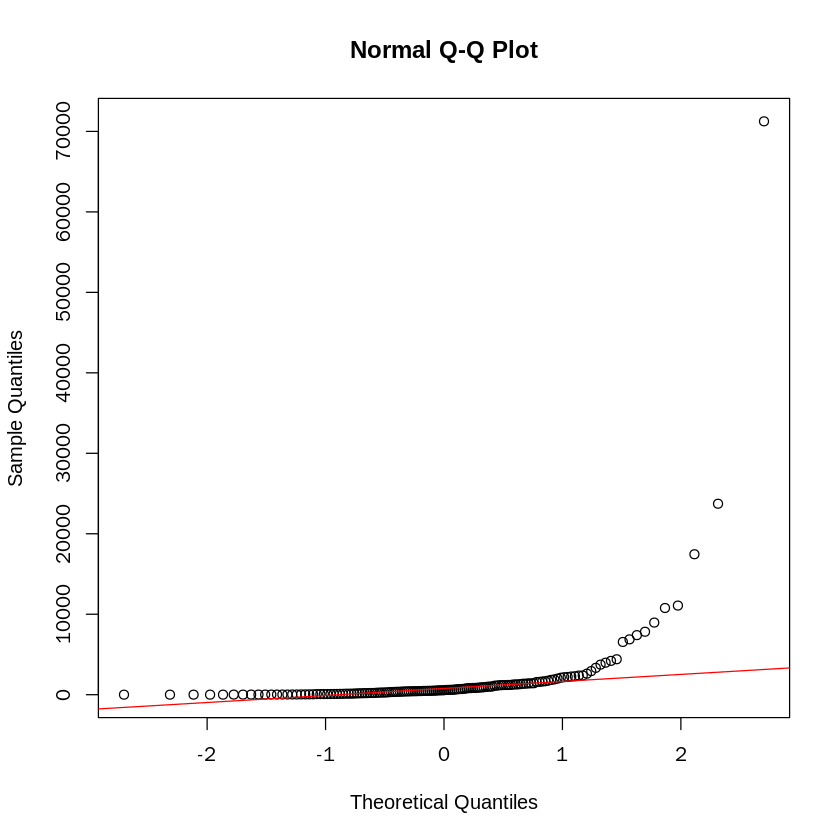

In [53]:
qqnorm(colMeans(mrna_p_uni, na.rm = TRUE))
qqline(colMeans(mrna_p_uni, na.rm = TRUE), col=2)

In [54]:
shapiro.test(colMeans(mrna_p_multi, na.rm = TRUE))


	Shapiro-Wilk normality test

data:  colMeans(mrna_p_multi, na.rm = TRUE)
W = 0.26178, p-value < 2.2e-16


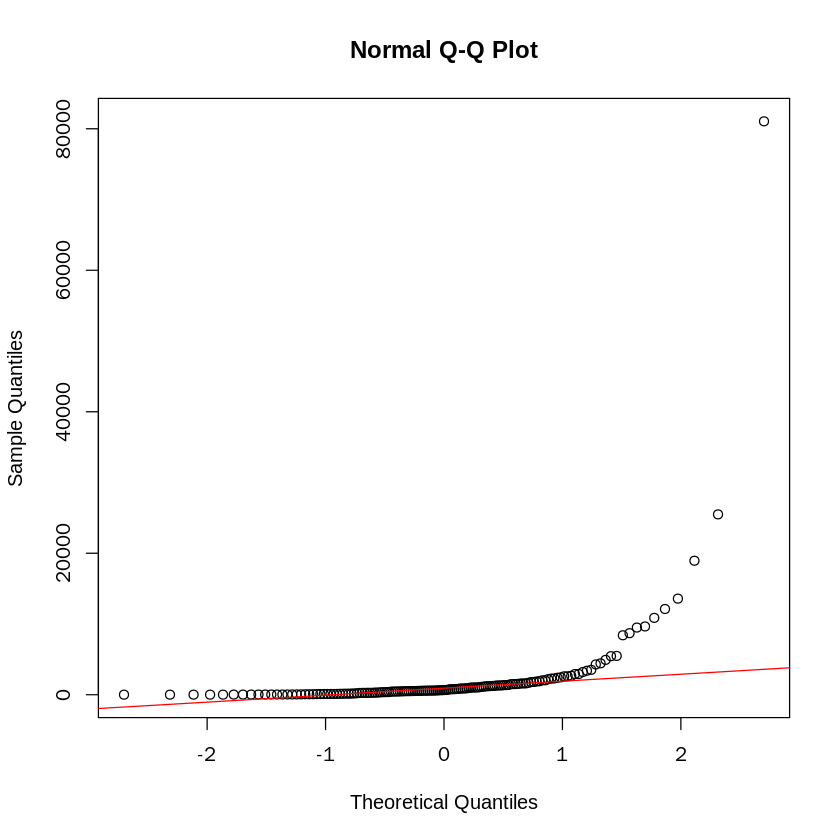

In [55]:
qqnorm(colMeans(mrna_p_multi, na.rm = TRUE))
qqline(colMeans(mrna_p_multi, na.rm = TRUE), col=2)

---
### loading miRNA

In [19]:
load("miRNA.RData")


#miRNA df name col 분리

name <- rownames(miRNA)
rownames(miRNA) <- NULL
miRNA <- cbind(name,miRNA)


#miRNA name 형식 변경
#TCGA-DJ-A2Q5-01A-11R-A18B-13 type >>> TCGA.BJ.A0YZ.01 type(clinical2)

miRNA$name <- gsub("-", ".", miRNA$name)
miRNA$name <- substr(miRNA$name, 1, 15)

count.zero <- sapply(1:ncol(miRNA), function(i) sum(miRNA[, i] == 0)) 
selected.mirna <- names(miRNA)[which(count.zero/nrow(miRNA) < 0.1)]
del.mirna <- setdiff(names(miRNA), selected.mirna)

mirna <- miRNA[, selected.mirna]
#mirna[mirna == 0] <- NA
                     
p_uni_miRNA <- merge(clinical_p_uni, mirna, by.x = "name", by.y = "name", all.x = TRUE)
p_multi_miRNA <- merge(clinical_p_multi, mirna, by.x = "name", by.y = "name", all.x = TRUE)

mirna_p_uni <- p_uni_miRNA[4:ncol(p_uni_miRNA)]
mirna_p_multi <- p_multi_miRNA[4:ncol(p_multi_miRNA)]

---
### miRNA 정규성 검정
* p-value < 0.05 이므로 정규분포를 따르지 않는다. 따라서, spearman 상관분석을 이용함
* 또한, 이상치가 존재해 (Q-Q plot을 근거로 함) 이상치에 민감한 pearson 상관분석을 이용하지 않는다

In [56]:
shapiro.test(colMeans(mirna_p_uni, na.rm = TRUE))


	Shapiro-Wilk normality test

data:  colMeans(mirna_p_uni, na.rm = TRUE)
W = 0.16599, p-value < 2.2e-16


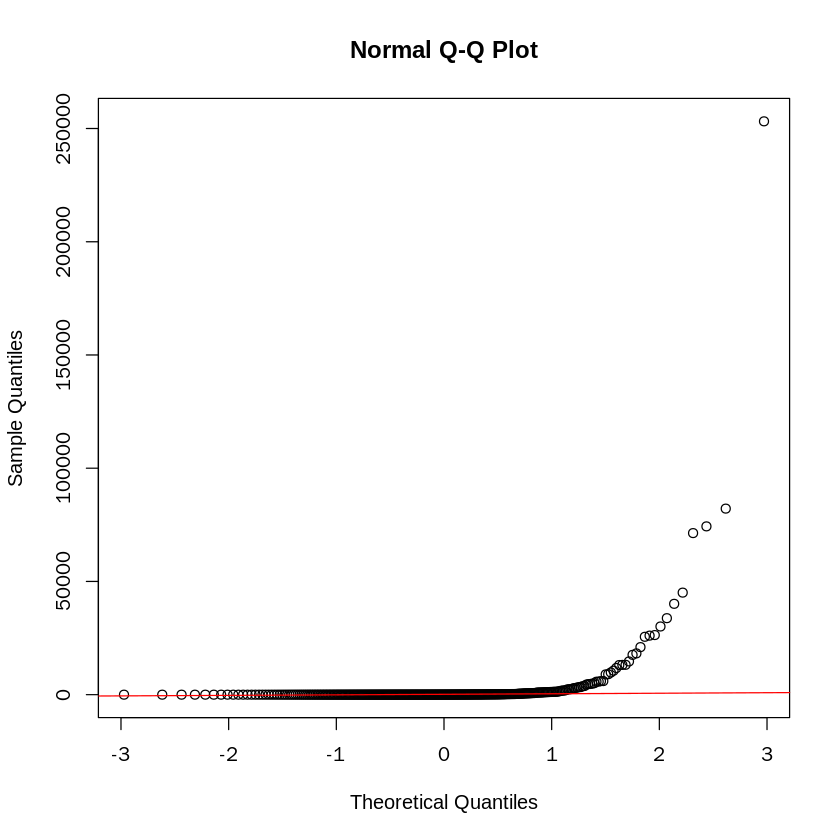

In [57]:
qqnorm(colMeans(mirna_p_uni, na.rm = TRUE))
qqline(colMeans(mirna_p_uni, na.rm = TRUE), col=2)

In [58]:
shapiro.test(colMeans(mirna_p_multi, na.rm = TRUE))


	Shapiro-Wilk normality test

data:  colMeans(mirna_p_multi, na.rm = TRUE)
W = 0.18451, p-value < 2.2e-16


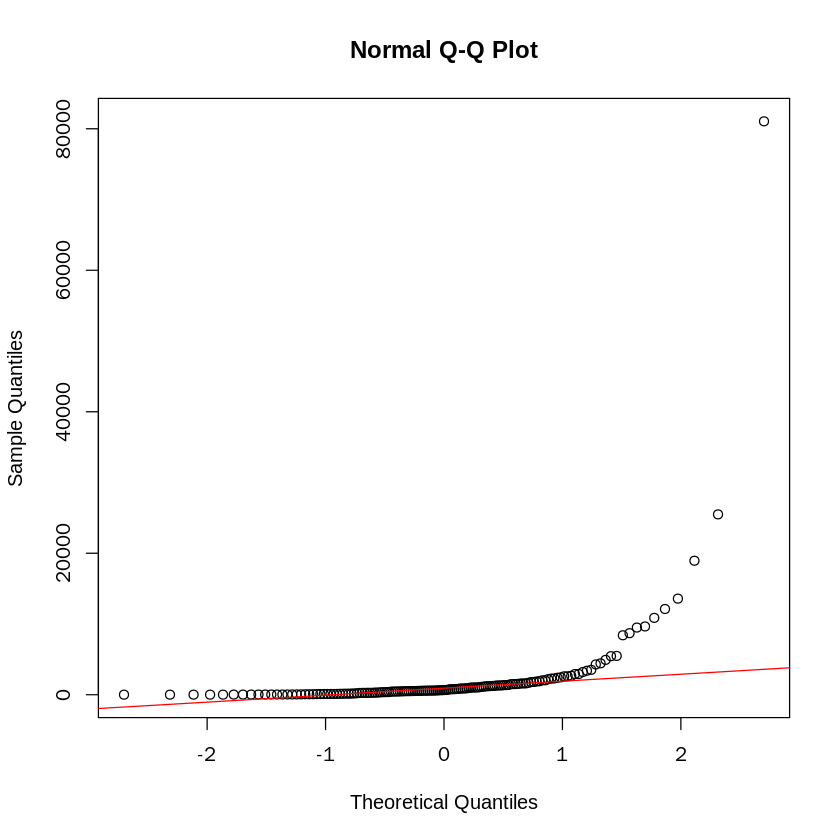

In [59]:
qqnorm(colMeans(mrna_p_multi, na.rm = TRUE))
qqline(colMeans(mrna_p_multi, na.rm = TRUE), col=2)

---
### corrtest

In [42]:
run <- readline("type? (u/m): ")

if (run == "u"){
    corr_rna <- data.frame(mrna_p_uni, mirna_p_uni)
}else{
    corr_rna <- data.frame(mrna_p_multi, mirna_p_multi)
}

result_rcorr <- rcorr(as.matrix(corr_rna), type = "spearman")

result_rcorr$r <- result_rcorr$r[1:ncol(mrna_p_uni),(ncol(result_rcorr$r)-ncol(mirna_p_uni)+1):ncol(result_rcorr$r)]
result_rcorr$P <- result_rcorr$P[1:ncol(mrna_p_uni),(ncol(result_rcorr$P)-ncol(mirna_p_uni)+1):ncol(result_rcorr$P)]

In [ ]:
#평균 -.2 미만의 correlation value를 가지는 데이터를 제외하고 cutoff
del <- ""
for(i in 1:ncol(result_path)-1){
    if(mean(result_path[,i+1])>(-0.2)){
        del <- c(del, NA)
    }else{
        del <- c(del, 1)
    }
}


#making NA col
del <- del[2:length(del)]
del <- t(data.frame(del))


#NA col : result binding
result_path <- rbind(result_path, del)
result_path_pval <- rbind(result_path_pval, del)


#----------NA row remove function----------
result_path <- t(na_rm(t(result_path)))
result_path_pval <- t(na_rm(t(result_path)))
result_path <- result_path[1:nrow(result_path)-1,]
result_path_pval <- result_path_pval[1:nrow(result_path_pval)-1,]
#----------NA row remove function----------


#data output
if (run == "u"){
    write.csv(result_rcorr$r, "corr_uni.csv")
    write.csv(result_rcorr$P, "corr_uni_pval.csv")
}else{
    write.csv(result_rcorr$r, "corr_multi.csv")
    write.csv(result_rcorr$P, "corr_multi_pval.csv")
}

---
### data selection by pathway

In [6]:
wnt_pluri <- c('AXIN2','CCND2','FZD3','FZD4','CD44')
neural <- c('AXIN2','ETS1','FZD3','HEY2','TCF4')
O_linked <- c('ADAMTS9','ADAMTSL2','B4GALT6','THSD7B') #GALNT16 missing
axon <- c('BMPR2','BOC','FZD3','PIK3R3','SLIT3','TRPC4')
TCF <- c('AXIN2','FZD4','HIST1H2AC','HIST1H4H','RNF146','TCF4')
sig_pluri <- c('AXIN2','BMPR2','FZD3','FZD4','PIK3R3')
ectoderm <- c('BCAS3','BOC','ELOVL2','FZD4','PODXL')
phosphoD <- c('AGPAT5','PDGFD','PIK3R3','RALB','RAPGEF4')
rap1 <- c('ARAP3','PDGFD','PIK3R3','RALB','RAPGEF4','TEK')
breast <- c('AXIN2','FZD3','FZD4','HEY2','PIK3R3')
gastric <- c('ABCB1','AXIN2','FZD3','FZD4','PIK3R3')
sig_wnt <- c('AXIN2','FZD3','FZD4','HIST1H2AC','HIST1H4H','RNF146','TCF4')
hippo <- c('AXIN2','BMPR2','CCND2','FZD3','FZD4')

In [7]:
result_t <- t(result_rcorr$r)
result_t_pval <- t(result_rcorr$P)

target <- hippo

result_path <- t(result_t[, target])
result_path_pval <- t(result_t_pval[, target])

In [8]:
#corr_value check (>-0.1 = NA)
del <- ""
for(i in 1:ncol(result_path)-1){
    if(max(result_path[,i+1])>(-0.1)){
        del <- c(del, NA)
    }else{
        del <- c(del, 1)
    }
}


#making NA col
del <- del[2:length(del)]
del <- t(data.frame(del))


#NA col : result binding
result_path <- rbind(result_path, del)
result_path_pval <- rbind(result_path_pval, del)


#----------NA row remove function----------
result_path <- t(na_rm(t(result_path)))
result_path_pval <- t(na_rm(t(result_path)))
result_path <- result_path[1:nrow(result_path)-1,]
result_path_pval <- result_path_pval[1:nrow(result_path_pval)-1,]
#----------NA row remove function----------


#data output
if (run == "u"){
    write.csv(result_rcorr$r, "corr_uni.csv")
    write.csv(result_rcorr$P, "corr_uni_pval.csv")
}else{
    write.csv(result_rcorr$r, "corr_multi.csv")
    write.csv(result_rcorr$P, "corr_multi_pval.csv")
}

---
### corrplot

In [ ]:
#corrplot
corrplot(result_path, method = "shade", tl.cex = 1, tl.col = "black", cl.cex = 1, cl.lim = c(-1, 0))

In [ ]:
#img output
png(file="corr.png", res=300, width = 640, height = 2560)

corrplot(result_rcorr$r, method = "color", tl.cex = 0.3, tl.col = "black", cl.cex = 0.5)

dev.off()